In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from core.data import DataGenerator, DatasetsDG
from core.models import SimpleNN, EnsembleModel, SimpleCNN, VAE, reload_vae_model
from core.optimization import run_nsga, NSGAConfig, FactualBasedSampling

## 1. Load Dataset and Classifier Models

In [2]:
# Image size configuration - using 16x16 to match VAE input
IMG_SIZE = 16
LATENT_DIM = 2  # VAE latent dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transform for classifier (normalized)
transform_classifier = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize((0.5,), (0.5,))
])

# Transform for VAE (no normalization, values in [0, 1])
transform_vae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

train_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=True, download=True, transform=transform_classifier)
train_dataset_vae = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=True, download=True, transform=transform_vae)

DG = DatasetsDG(train_dataset, num_classes=10)
DG_vae = DatasetsDG(train_dataset_vae, num_classes=10)

Using device: cuda


In [3]:
# Train classifier ensemble (same as demo_minist.ipynb)
models = [SimpleCNN(16, 16, input_channels=1, num_classes=10) for _ in range(10)]

for model in models:
    model.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 100
for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    seed = 42 + hash(model) % 1000
    samples = DG.sample(5000, seed=seed)
    model_train_dataset = TensorDataset(samples[0].to(device), samples[1].to(device))
    train_loader = DataLoader(model_train_dataset, batch_size=512, shuffle=True)
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    for epoch in bar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix(loss=running_loss/(epoch+1))

Training Model: 100%|██████████| 100/100 [00:06<00:00, 14.74epoch/s, loss=2.75]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.52epoch/s, loss=2.92]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.66epoch/s, loss=3.27]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.34epoch/s, loss=3]  

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.49epoch/s, loss=2.94]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.00epoch/s, loss=3.23]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.29epoch/s, loss=2.7]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.25epoch/s, loss=3.49]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 14.91epoch/s, loss=3.03]

Training Model: 100%|██████████| 100/100 [00:06<00:00, 15.05epoch/s, loss=3.21]


## 2. Load Pre-trained Unified VAE Model (All Digits)

Loaded unified VAE model from: e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_all_digits.pth


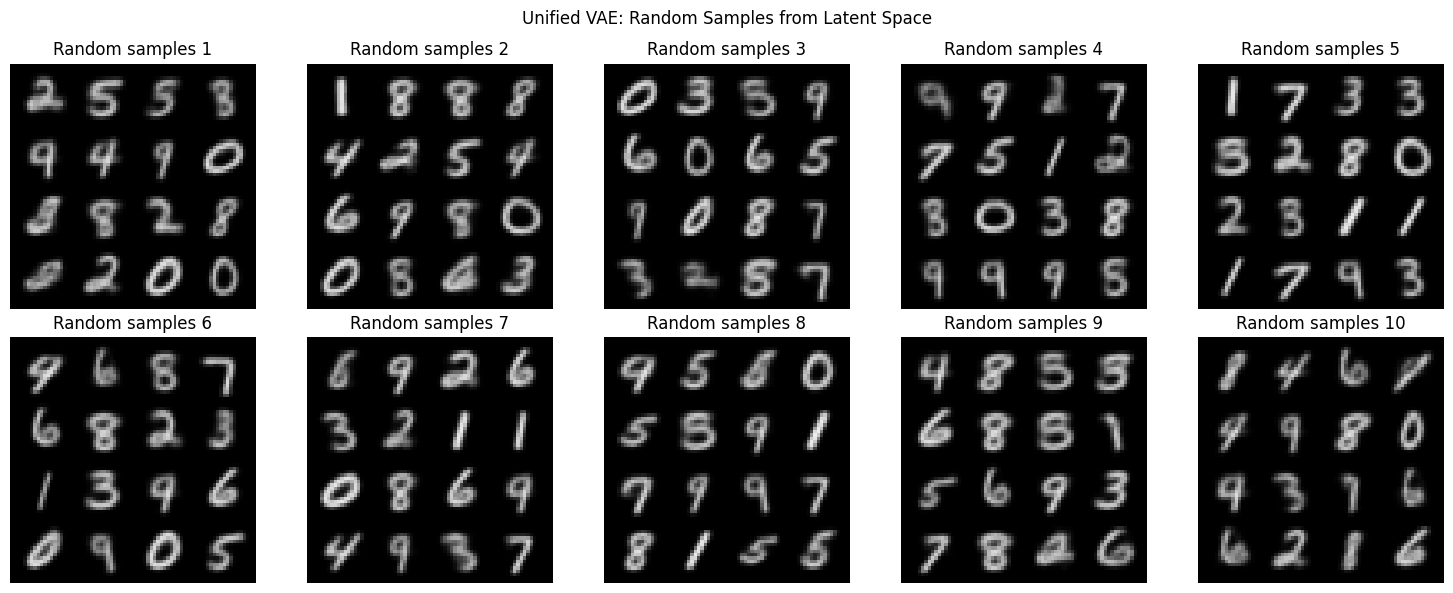

In [4]:
# Load the unified VAE model (trained on all digits)
vae_path = os.path.join(root_dir, 'saved_models', 'vae_mnist_all_digits.pth')
vae_model = VAE(latent_dim=LATENT_DIM, in_channels=1)
vae_model.load_state_dict(torch.load(vae_path, map_location=device, weights_only=True))
vae_model.to(device)
vae_model.eval()
print(f"Loaded unified VAE model from: {vae_path}")

# Visualize VAE generation quality - sample from latent space
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
with torch.no_grad():
    # Sample different regions of the 2D latent space
    for i in range(10):
        z = torch.randn(16, LATENT_DIM).to(device)
        samples = vae_model.decode(z).cpu()
        ax[i//5, i%5].imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
        ax[i//5, i%5].set_title(f"Random samples {i+1}")
        ax[i//5, i%5].axis('off')
plt.suptitle("Unified VAE: Random Samples from Latent Space")
plt.tight_layout()
plt.show()

## 3. Define Latent Space CF Problem

We create a custom problem class that:
1. Takes latent vectors z as decision variables (2D) - **sampling in latent space**
2. Uses VAE decoder to generate images from z
3. Evaluates objectives on the generated images - **distance computed in image space (256D)**

In [20]:
from pymoo.core.problem import Problem
from core.cf_problem import epistemic_from_models_tensor, aleatoric_from_models_tensor
from typing import Callable, Union

class LatentSpaceCFProblem(Problem):
    """
    Counterfactual optimization in VAE latent space.
    
    Decision variables: z ∈ R^latent_dim (e.g., 2D)
    VAE decoder generates image: x = decoder(z)
    
    Objectives are computed in IMAGE SPACE (not latent space):
    - o1: Validity (1 - P(target))
    - o2: Epistemic Uncertainty (using ensemble)
    - o3: Image Space Distance (L2 distance in pixel space)
    - o4: -Aleatoric Uncertainty (negated to maximize)
    """
    
    def __init__(
        self,
        classifier: nn.Module,
        vae_decoder: Union[nn.Module, Callable],
        z_factual: torch.Tensor,
        x_factual: torch.Tensor,  # NEW: factual image for distance calculation
        y_target: torch.Tensor,
        ensemble: EnsembleModel,
        latent_dim: int = 2,
        z_bounds: float = 2.0,  # Latent space typically bounded by ~3-4 std
        device: torch.device = None,
        normalize_for_classifier: bool = True,
    ):
        self.classifier = classifier
        self.vae_decoder = vae_decoder
        self.ensemble = ensemble
        self.latent_dim = latent_dim
        self.device = device if device else torch.device('cpu')
        self.normalize_for_classifier = normalize_for_classifier
        
        # Store factual latent vector (for reference)
        self.z_factual = z_factual.flatten().to(self.device)
        
        # Store factual IMAGE for distance calculation (flattened)
        # x_factual should be in [0, 1] range (VAE output format)
        self.x_factual = x_factual.flatten().to(self.device)
        self.image_size = x_factual.numel()  # Total pixels (e.g., 1*16*16=256)
        
        self.target_labels = y_target.view(-1).long().to(self.device)
        
        # Set models to eval mode
        classifier.eval()
        # Only call eval() if vae_decoder is a nn.Module, not a function
        if isinstance(vae_decoder, nn.Module):
            vae_decoder.eval()
        for m in ensemble.models:
            m.eval()
        
        # Initialize pymoo Problem
        super().__init__(
            n_var=latent_dim,
            n_obj=4,
            xl=-z_bounds * np.ones(latent_dim),
            xu=z_bounds * np.ones(latent_dim),
        )
    
    def decode_raw(self, z_batch: torch.Tensor) -> torch.Tensor:
        """Decode latent vectors to raw images in [0, 1] range."""
        with torch.no_grad():
            # VAE decoder outputs in [0, 1]
            x_generated = self.vae_decoder(z_batch)  # (N, 1, 16, 16)
            return x_generated
    
    def decode_and_normalize(self, z_batch: torch.Tensor) -> torch.Tensor:
        """Decode latent vectors and normalize for classifier."""
        x_generated = self.decode_raw(z_batch)
        
        if self.normalize_for_classifier:
            # Normalize to [-1, 1] for classifier (same as training transform)
            x_normalized = (x_generated - 0.5) / 0.5
            return x_normalized
        return x_generated
    
    def _evaluate(self, X: np.ndarray, out: dict, *args, **kwargs):
        """
        Evaluate objectives for batch of latent vectors.
        
        Args:
            X: Latent vectors, shape (pop_size, latent_dim)
        """
        # Convert to tensor
        Z_t = torch.from_numpy(X).float().to(self.device)
        batch_size = Z_t.shape[0]
        
        # Decode latent vectors to raw images (for distance calculation)
        with torch.no_grad():
            X_images_raw = self.decode_raw(Z_t)  # [0, 1] range
        
        # Normalize for classifier
        if self.normalize_for_classifier:
            X_images_clf = (X_images_raw - 0.5) / 0.5
        else:
            X_images_clf = X_images_raw
        
        # ===== OBJECTIVE 1: Validity =====
        with torch.no_grad():
            logits = self.classifier(X_images_clf)
            probs = torch.softmax(logits, dim=1)
        
        prob_target = probs[:, self.target_labels].sum(dim=1)
        f1_validity = 1.0 - prob_target
        
        # ===== OBJECTIVE 2: Epistemic Uncertainty =====
        f2_epistemic = epistemic_from_models_tensor(self.ensemble, X_images_clf)
        
        # ===== OBJECTIVE 3: Image Space Distance (L2 in pixel space) =====
        # Flatten generated images and compute L2 distance to factual image
        X_images_flat = X_images_raw.view(batch_size, -1)  # (N, 256)
        f3_image_dist = torch.norm(X_images_flat - self.x_factual, dim=1)
        
        # ===== OBJECTIVE 4: -Aleatoric Uncertainty =====
        f4_aleatoric_neg = -aleatoric_from_models_tensor(self.ensemble, X_images_clf)
        
        # Stack objectives
        F = torch.stack([f1_validity, f2_epistemic, f3_image_dist, f4_aleatoric_neg], dim=1)
        out['F'] = F.cpu().numpy()

## 4. Select Factual Instance and Target Class

Factual label: 9


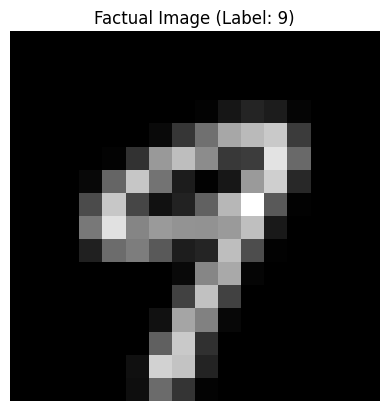

Target class: 8


In [21]:
# Sample a factual instance (use VAE transform - no normalization)
x_factual_vae, y_factual = DG_vae.sample(1, seed=1234)
x_factual_vae = x_factual_vae.to(device)

# Also get the normalized version for classifier
x_factual_clf, _ = DG.sample(1, seed=1234)
x_factual_clf = x_factual_clf.to(device)

factual_label = y_factual.argmax().item()
print(f"Factual label: {factual_label}")

plt.imshow(x_factual_vae[0].squeeze().cpu(), cmap='gray')
plt.title(f'Factual Image (Label: {factual_label})')
plt.axis('off')
plt.show()

# Set target class (different from factual)
target_class = 8 if factual_label != 8 else 3
target_class_tensor = torch.tensor([target_class], device=device)
print(f"Target class: {target_class}")

Factual latent vector z: [[0.48432675 0.5190798 ]]
Latent space dimension: 2


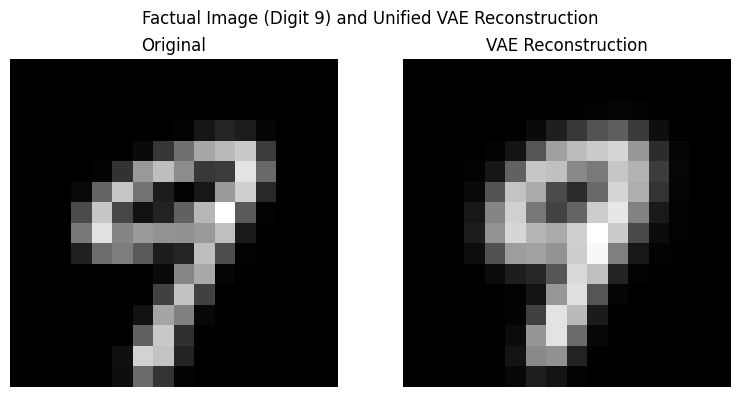

In [22]:
# Encode factual image to latent space using the unified VAE
with torch.no_grad():
    mu, logvar = vae_model.encode(x_factual_vae)
    z_factual = mu  # Use mean as the factual latent representation

print(f"Factual latent vector z: {z_factual.cpu().numpy()}")
print(f"Latent space dimension: {z_factual.shape[-1]}")

# Verify reconstruction using the unified VAE
with torch.no_grad():
    x_reconstructed = vae_model.decode(z_factual)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x_factual_vae[0].squeeze().cpu(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(x_reconstructed[0].squeeze().cpu(), cmap='gray')
axes[1].set_title('VAE Reconstruction')
axes[1].axis('off')
plt.suptitle(f'Factual Image (Digit {factual_label}) and Unified VAE Reconstruction')
plt.tight_layout()
plt.show()

## 5. Run NSGA-II in Latent Space

Now we optimize in the unified 2D latent space where all digits are represented together.

In [61]:
# Use the unified VAE decoder for generating counterfactuals
# (same VAE for all digits - shared latent space)

# Create the latent space CF problem
ensemble = EnsembleModel(models)

# x_factual_vae is the original factual image in [0, 1] range (VAE format)
# This is used for computing distance in IMAGE SPACE, not latent space
latent_problem = LatentSpaceCFProblem(
    classifier=models[0],
    vae_decoder=vae_model.decode,  # Use unified VAE decoder
    z_factual=z_factual,
    x_factual=x_factual_vae,  # Pass factual image for image-space distance
    y_target=target_class_tensor,
    ensemble=ensemble,
    latent_dim=LATENT_DIM,
    z_bounds=4.0,
    device=device,
    normalize_for_classifier=True,
)

print(f"Problem dimensions: {latent_problem.n_var}D latent space (unified for all digits)")
print(f"Objectives: [Validity, Epistemic, Image Distance, -AU]")
print(f"Distance computed in: {latent_problem.image_size}D image space (pixels)")

Problem dimensions: 2D latent space (unified for all digits)
Objectives: [Validity, Epistemic, Image Distance, -AU]
Distance computed in: 256D image space (pixels)


In [62]:
# Custom sampling starting from factual latent vector
from pymoo.operators.sampling.rnd import FloatRandomSampling

class LatentFactualSampling(FloatRandomSampling):
    """Sample around factual latent vector with Gaussian noise."""
    def __init__(self, z_factual, noise_scale=0.5):
        super().__init__()
        self.z_factual = z_factual.cpu().numpy().flatten()
        self.noise_scale = noise_scale
    
    def _do(self, problem, n_samples, **kwargs):
        # Sample around factual latent vector
        Z = np.tile(self.z_factual, (n_samples, 1))
        noise = np.random.normal(0, self.noise_scale, Z.shape)
        Z = Z + noise
        # Clip to bounds
        Z = np.clip(Z, problem.xl, problem.xu)
        return Z

# Generate observed latent vectors for conditional mutator
# Sample latent vectors from the target VAE's prior distribution
n_obs_samples = 10000
z_obs = np.random.randn(n_obs_samples, LATENT_DIM).astype(np.float32)
z_obs = np.clip(z_obs * 2.0, -2.0, 2.0)  # Scale and clip to match z_bounds
print(f"Generated {n_obs_samples} observed latent vectors for conditional mutator")

Generated 10000 observed latent vectors for conditional mutator


In [63]:
# Use our library's run_nsga and NSGAConfig interface
from core.optimization import run_nsga, NSGAConfig

# Configure NSGA-II using our library's settings
nsga_config = NSGAConfig()
nsga_config.pop_size = 200
nsga_config.min_gen = 1400
nsga_config.max_gen = 1800
nsga_config.use_valid_cf_termination = True
nsga_config.min_valid_cf = 25
nsga_config.validity_threshold = 0.3

# MOC-style operators (adapted for latent space)
nsga_config.use_conditional_mutator = True
nsga_config.conditional_mutator_prob = 0.7
nsga_config.use_reset_operator = True
nsga_config.reset_prob = 0.1  # Higher reset prob for 2D space

# Mutation parameters - higher for small latent space
nsga_config.mutation_prob = 0.5
nsga_config.mutation_eta = 20

nsga_config.verbose = True
nsga_config.seed = 42

print("Running NSGA-II optimization in latent space using our library...")
print(f"Config: pop_size={nsga_config.pop_size}, max_gen={nsga_config.max_gen}")
print(f"MOC operators: conditional_mutator={nsga_config.use_conditional_mutator}, reset={nsga_config.use_reset_operator}")

# Run optimization using our library's interface
results = run_nsga(
    problem=latent_problem,
    config=nsga_config,
    sampling=LatentFactualSampling(z_factual, noise_scale=1.0),
    X_obs=z_obs,  # Observed latent vectors for conditional mutator
    x_factual=z_factual,  # Factual latent vector for reset operator
    device=device,
)

print(f"\nOptimization complete!")
print(f"Found {len(results.X)} solutions")
print(f"Latent space shape: {results.X.shape}")

Running NSGA-II optimization in latent space using our library...
Config: pop_size=200, max_gen=1800
MOC operators: conditional_mutator=True, reset=True
Gen    1 | Valid CFs (pop):  28 | Pareto front: 139 | Best P(target): 1.000 | Mean Sparsity: 3.186
Gen    1 | Valid CFs (pop):  28 | Pareto front: 139 | Best P(target): 1.000 | Mean Sparsity: 3.186
Gen   10 | Valid CFs (pop):  33 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.331
Gen   10 | Valid CFs (pop):  33 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.331
Gen   20 | Valid CFs (pop):  37 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.300
Gen   20 | Valid CFs (pop):  37 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.300
Gen   30 | Valid CFs (pop):  43 | Pareto front: 200 | Best P(target): 0.977 | Mean Sparsity: 3.256
Gen   30 | Valid CFs (pop):  43 | Pareto front: 200 | Best P(target): 0.977 | Mean Sparsity: 3.256
Gen   40 | Valid CFs (pop):  42 | Pareto front: 200 | B

In [88]:
# Option to continue training from previous results
CONTINUE_TRAINING = True  # Set to True to continue from previous results

if CONTINUE_TRAINING and 'results' in dir() and results is not None:
    print("="*70)
    print("CONTINUING TRAINING FROM PREVIOUS RESULTS")
    print("="*70)
    print(f"Previous results: {len(results.X)} solutions")
    print(f"Previous valid solutions (validity < 0.3): {np.sum(results.F[:, 0] < 0.3)}")
    
    # Use the previous results as initial sampling with some noise
    prev_X = results.X.copy()
    prev_F = results.F.copy()
    
    # Create sampling that uses previous results
    class PreviousResultsSampling(FloatRandomSampling):
        """Sample from previous results with optional noise for continued optimization."""
        def __init__(self, prev_results, noise_scale=0.05):
            super().__init__()
            self.prev_results = prev_results
            self.noise_scale = noise_scale
        
        def _do(self, problem, n_samples, **kwargs):
            n_prev = len(self.prev_results)
            if n_samples <= n_prev:
                indices = np.random.choice(n_prev, size=n_samples, replace=False)
                X = self.prev_results[indices].copy()
            else:
                # If we need more samples, repeat and add noise
                X = np.tile(self.prev_results, (n_samples // n_prev + 1, 1))[:n_samples]
            
            # Add small noise to explore nearby regions
            if self.noise_scale > 0:
                noise = np.random.normal(0, self.noise_scale, X.shape)
                X = X + noise
            
            # Clip to bounds
            X = np.clip(X, problem.xl, problem.xu)
            return X
    
    # Configure continued training
    nsga_continue_config = NSGAConfig()
    nsga_continue_config.pop_size = min(len(prev_X), 300)
    nsga_continue_config.min_gen = 2000   # Additional generations
    nsga_continue_config.max_gen = 3000
    nsga_continue_config.use_valid_cf_termination = True
    nsga_continue_config.min_valid_cf = 70  # Try to find more valid CFs
    nsga_continue_config.validity_threshold = 0.3
    
    # Keep MOC-style operators
    nsga_continue_config.use_conditional_mutator = True
    nsga_continue_config.conditional_mutator_prob = 0.7
    nsga_continue_config.use_reset_operator = True
    nsga_continue_config.reset_prob = 0.05  # Slightly higher for exploration
    
    nsga_continue_config.mutation_prob = 0.5
    nsga_continue_config.mutation_eta = 20
    nsga_continue_config.verbose = True
    nsga_continue_config.seed = 123  # Different seed for continuation
    
    print(f"\nContinued training config:")
    print(f"  pop_size={nsga_continue_config.pop_size}, max_gen={nsga_continue_config.max_gen}")
    print(f"  Starting from {len(prev_X)} previous solutions")
    
    # Run continued optimization
    continue_sampling = PreviousResultsSampling(prev_X, noise_scale=0.1)
    results = run_nsga(
        problem=latent_problem,
        config=nsga_continue_config,
        sampling=continue_sampling,
        X_obs=z_obs,
        x_factual=z_factual,
        device=device,
    )
    
    print(f"\n" + "="*70)
    print("CONTINUED TRAINING COMPLETE")
    print("="*70)
    print(f"Total solutions: {len(results.X)}")
    print(f"Valid solutions (validity < 0.3): {np.sum(results.F[:, 0] < 0.3)}")
    
    # Compare with previous results
    prev_valid = np.sum(prev_F[:, 0] < 0.3)
    new_valid = np.sum(results.F[:, 0] < 0.3)
    print(f"Improvement: {prev_valid} → {new_valid} valid CFs ({new_valid - prev_valid:+d})")
else:
    print("No previous results found or CONTINUE_TRAINING is False.")
    print("Run the initial optimization cell first.")

CONTINUING TRAINING FROM PREVIOUS RESULTS
Previous results: 200 solutions
Previous valid solutions (validity < 0.3): 39

Continued training config:
  pop_size=200, max_gen=3000
  Starting from 200 previous solutions
Gen    1 | Valid CFs (pop):  32 | Pareto front: 128 | Best P(target): 1.000 | Mean Sparsity: 3.148
Gen   10 | Valid CFs (pop):  34 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.305
Gen   20 | Valid CFs (pop):  42 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.353
Gen   30 | Valid CFs (pop):  40 | Pareto front: 200 | Best P(target): 0.987 | Mean Sparsity: 3.227
Gen   40 | Valid CFs (pop):  41 | Pareto front: 200 | Best P(target): 0.977 | Mean Sparsity: 3.201
Gen   50 | Valid CFs (pop):  43 | Pareto front: 200 | Best P(target): 1.000 | Mean Sparsity: 3.296
Gen   60 | Valid CFs (pop):  42 | Pareto front: 200 | Best P(target): 0.986 | Mean Sparsity: 3.165
Gen   70 | Valid CFs (pop):  47 | Pareto front: 200 | Best P(target): 0.994 | Mean Sparsity

## 6. Visualize Results

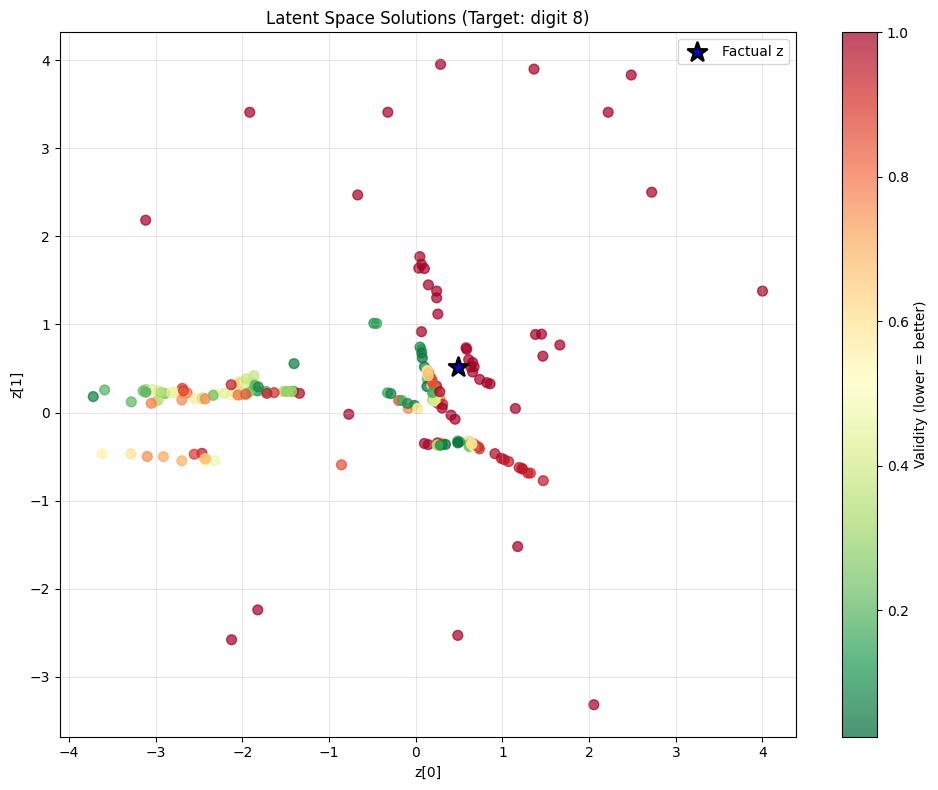

In [89]:
# Visualize the latent space search
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot all solutions colored by validity
validity = results.F[:, 0]
scatter = ax.scatter(results.X[:, 0], results.X[:, 1], c=validity, 
                     cmap='RdYlGn_r', s=50, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Validity (lower = better)')

# Mark factual point
ax.scatter(z_factual[0, 0].cpu(), z_factual[0, 1].cpu(), 
           c='blue', s=200, marker='*', label='Factual z', edgecolors='black', linewidths=2)

ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
ax.set_title(f'Latent Space Solutions (Target: digit {target_class})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# Get valid counterfactuals (validity < 0.3)
valid_mask = results.F[:, 0] < 0.3
valid_X = results.X[valid_mask]
valid_F = results.F[valid_mask]

print(f"Total solutions: {len(results.F)}")
print(f"Valid solutions (validity < 0.3): {len(valid_X)}")

if len(valid_X) == 0:
    print("No valid counterfactuals found. Using all solutions.")
    valid_X = results.X
    valid_F = results.F
    valid_mask = np.ones(len(results.F), dtype=bool)

Total solutions: 200
Valid solutions (validity < 0.3): 39


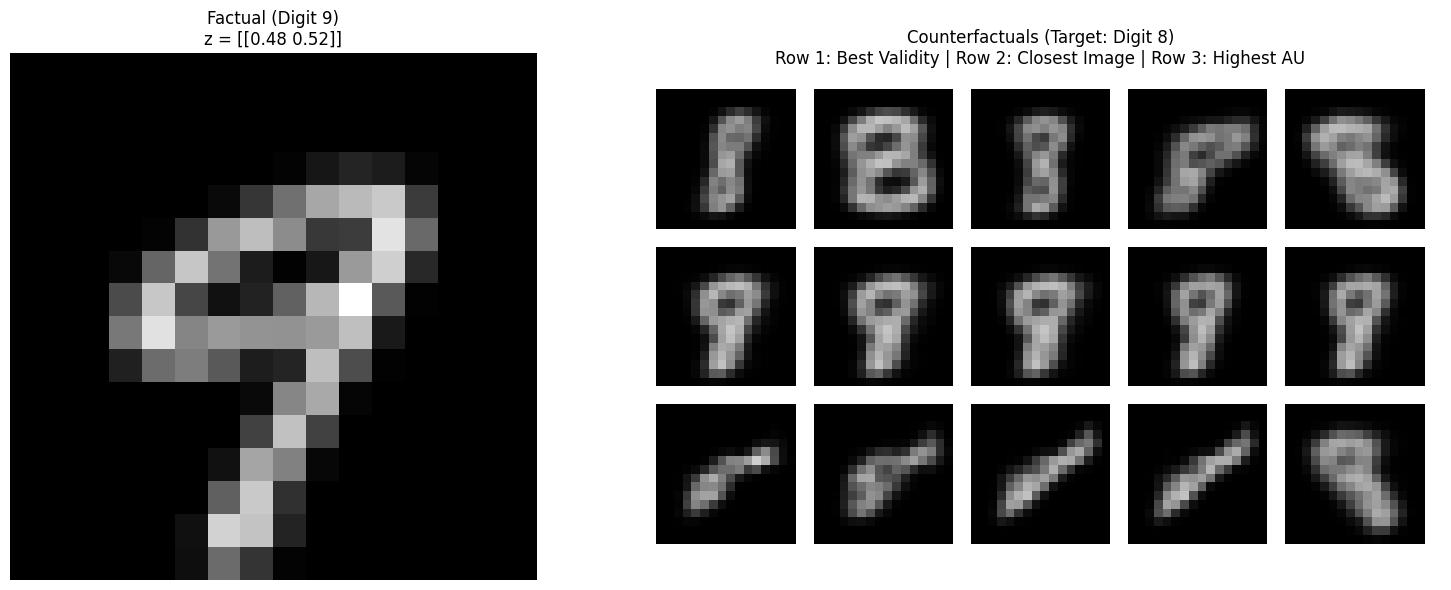

In [90]:
# Generate and display counterfactual images
num_to_display = 5

# Group 1: Best validity (most valid)
sorted_by_validity = np.argsort(valid_F[:, 0])
group1_indices = sorted_by_validity[:num_to_display]

# Group 2: Lowest image distance
sorted_by_dist = np.argsort(valid_F[:, 2])
group2_indices = sorted_by_dist[:num_to_display]

# Group 3: Best AU (highest, so lowest -AU)
sorted_by_au = np.argsort(valid_F[:, 3])  # -AU, so lowest is best
group3_indices = sorted_by_au[:num_to_display]

groups = [
    ("Best Validity", group1_indices),
    ("Closest in Image Space", group2_indices),
    ("Highest AU", group3_indices),
]

# Generate images using unified VAE
all_cf_images = []
all_z_values = []

with torch.no_grad():
    for group_name, indices in groups:
        for idx in indices:
            z = torch.tensor(valid_X[idx], dtype=torch.float32, device=device).unsqueeze(0)
            img = vae_model.decode(z).cpu()  # Use unified VAE
            all_cf_images.append(img.squeeze(0))
            all_z_values.append(valid_X[idx])

# Stack and create grid
cf_stack = torch.stack(all_cf_images)
cf_grid = make_grid(cf_stack, nrow=num_to_display, normalize=False, padding=2, pad_value=1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original factual
axes[0].imshow(x_factual_vae[0].squeeze().cpu(), cmap='gray')
axes[0].set_title(f'Factual (Digit {factual_label})\nz = {z_factual.cpu().numpy().round(2)}')
axes[0].axis('off')

# Counterfactual grid
axes[1].imshow(cf_grid.permute(1, 2, 0).numpy(), cmap='gray')
axes[1].set_title(f'Counterfactuals (Target: Digit {target_class})\nRow 1: Best Validity | Row 2: Closest Image | Row 3: Highest AU')
axes[1].axis('off')

plt.tight_layout()
plt.show()

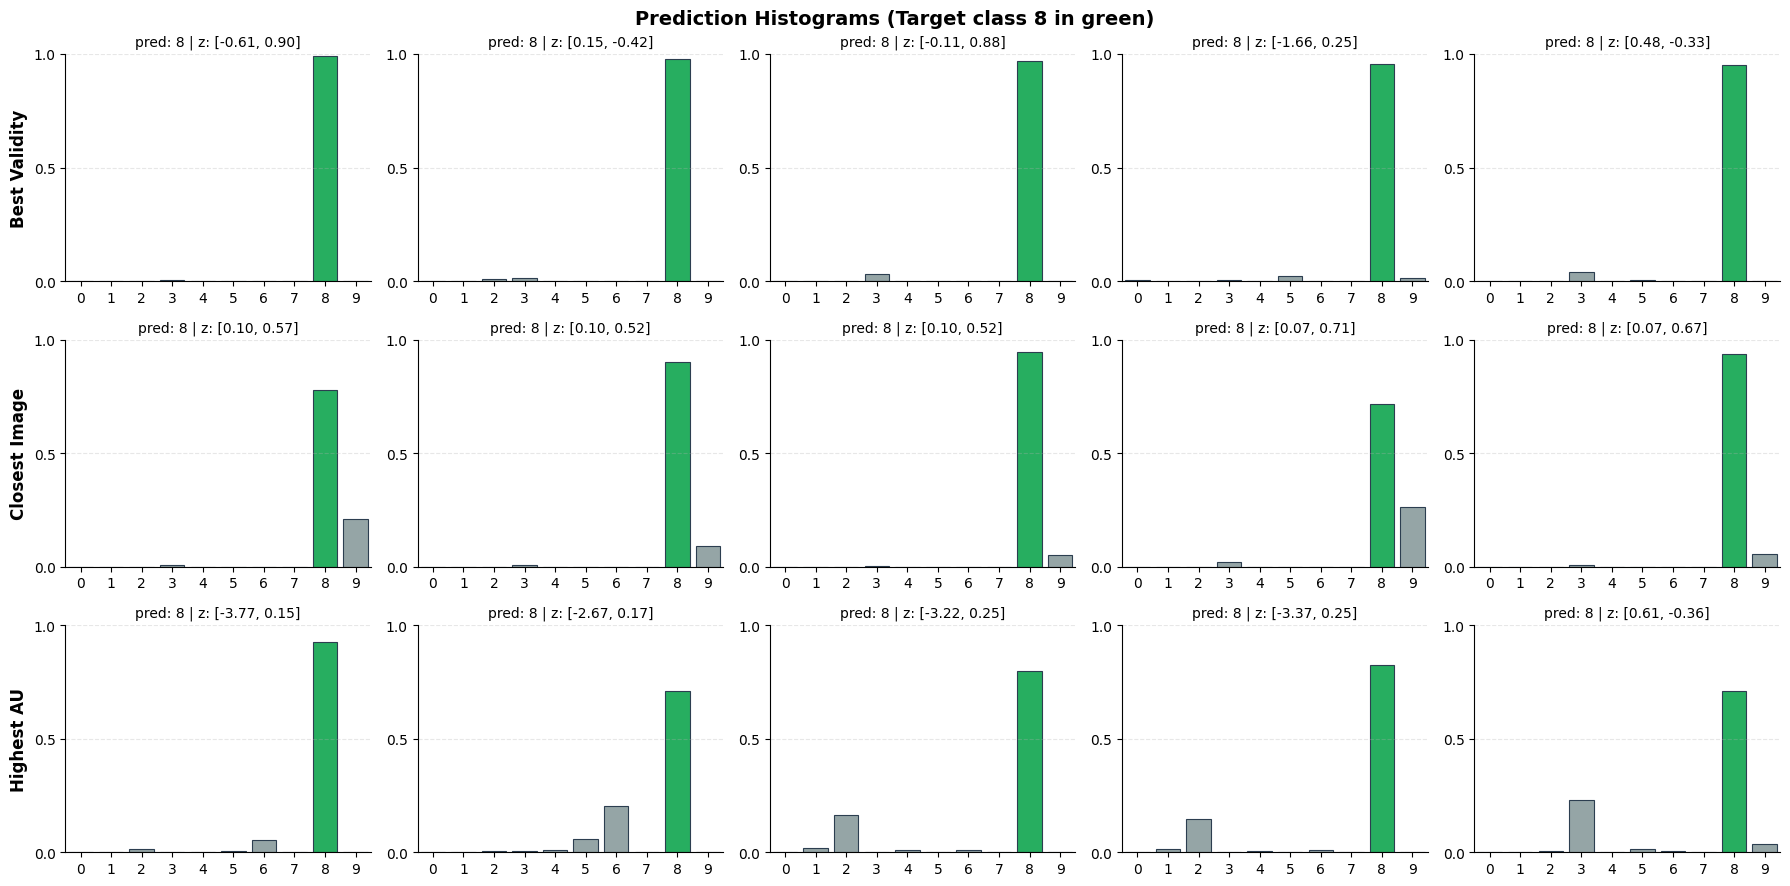

In [94]:
# Plot prediction histograms for counterfactuals
fig, axes = plt.subplots(3, num_to_display, figsize=(18, 9))
row_labels = ["Best Validity", "Closest Image", "Highest AU"]

cf_idx = 0
for g_idx, (group_name, indices) in enumerate(groups):
    for i, idx in enumerate(indices):
        z = torch.tensor(valid_X[idx], dtype=torch.float32, device=device).unsqueeze(0)
        
        with torch.no_grad():
            # Generate image from latent using unified VAE
            img_vae = vae_model.decode(z)  # [0, 1]
            # Normalize for classifier
            img_clf = (img_vae - 0.5) / 0.5
            probs = nn.functional.softmax(models[0](img_clf), dim=1).squeeze().cpu().numpy()
        
        pred = probs.argmax()
        obj_vals = valid_F[idx]
        au_value = -obj_vals[3]
        
        ax = axes[g_idx, i]
        colors = ['#27ae60' if j == target_class else '#95a5a6' for j in range(10)]
        ax.bar(range(10), probs, color=colors, edgecolor='#2c3e50', linewidth=0.8)
        ax.set_ylim(0, 1)
        ax.set_xlim(-0.5, 9.5)
        ax.set_xticks(range(10))
        ax.set_yticks([0, 0.5, 1])
        ax.tick_params(axis='both', labelsize=10)
        ax.set_title(f'pred: {pred} | z: [{valid_X[idx][0]:.2f}, {valid_X[idx][1]:.2f}]', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        if i == 0:
            ax.set_ylabel(row_labels[g_idx], fontsize=12, fontweight='bold')
        cf_idx += 1

plt.suptitle(f'Prediction Histograms (Target class {target_class} in green)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [79]:
# Print objective values summary
print("\n" + "="*70)
print("SUMMARY: Latent Space Counterfactual Generation")
print("="*70)
print(f"Factual digit: {factual_label} → Target digit: {target_class}")
print(f"Factual latent z: {z_factual.cpu().numpy().round(3)}")
print(f"Search space: {LATENT_DIM}D latent space")
print(f"Distance computed in: {latent_problem.image_size}D image space (pixels)")
print(f"\nObjectives: [Validity, Epistemic, Image Distance, -AU]")
print("-"*70)

for g_idx, (group_name, indices) in enumerate(groups):
    print(f"\n{group_name}:")
    for i, idx in enumerate(indices[:3]):  # Show top 3 per group
        obj = valid_F[idx]
        z_val = valid_X[idx]
        print(f"  CF {i+1}: z=[{z_val[0]:.3f}, {z_val[1]:.3f}], "
              f"Valid={obj[0]:.3f}, EU={obj[1]:.3f}, ImgDist={obj[2]:.3f}, AU={-obj[3]:.3f}")


SUMMARY: Latent Space Counterfactual Generation
Factual digit: 9 → Target digit: 8
Factual latent z: [[0.484 0.519]]
Search space: 2D latent space
Distance computed in: 256D image space (pixels)

Objectives: [Validity, Epistemic, Image Distance, -AU]
----------------------------------------------------------------------

Best Validity:
  CF 1: z=[0.082, 0.488], Valid=0.006, EU=0.007, ImgDist=2.735, AU=0.058
  CF 2: z=[-0.925, 0.201], Valid=0.014, EU=0.005, ImgDist=3.247, AU=0.041
  CF 3: z=[-0.236, 0.197], Valid=0.017, EU=0.010, ImgDist=3.711, AU=0.147

Closest in Image Space:
  CF 1: z=[0.138, 0.395], Valid=0.272, EU=0.116, ImgDist=2.609, AU=0.510
  CF 2: z=[0.072, 0.646], Valid=0.044, EU=0.089, ImgDist=2.709, AU=0.261
  CF 3: z=[0.135, 0.357], Valid=0.153, EU=0.058, ImgDist=2.732, AU=0.360

Highest AU:
  CF 1: z=[-4.000, 0.304], Valid=0.271, EU=0.253, ImgDist=3.580, AU=0.961
  CF 2: z=[-3.654, 0.118], Valid=0.114, EU=0.288, ImgDist=3.483, AU=0.838
  CF 3: z=[-2.849, 0.167], Valid=0.

In [91]:
# 3D plot for objective space (similar to demo_minist.ipynb)
import importlib
import utils
importlib.reload(utils)
from utils import plot_cf_3d

# For latent space, we use z_obs as context (sampled latent vectors)
# and z_factual as the factual point
plot_cf_3d(
    results=results,
    x_factual=z_factual.cpu().numpy().flatten(),
    context=z_obs  # Observed latent vectors as context
)

VERIFICATION: Image Space Distance Calculation

AU threshold (top 30%): 0.503553
Solutions with AU >= 0.503553: 12

Selected CF index: 3
  - Validity: 0.1617
  - EU: 0.100712 (min in top 30% AU)
  - ImgDist: 4.1045
  - AU: 0.544568 (top 30%)

Factual image: x_factual_vae
  - Source: Original MNIST digit 9
  - Shape: torch.Size([1, 1, 16, 16])
  - Value range: [0.000, 0.866]

Counterfactual image: vae_model.decode(z)
  - Source: Unified VAE decoder (all digits)
  - Shape: torch.Size([1, 1, 16, 16])
  - Value range: [0.000, 0.752]

Distance verification:
  - Manual L2 distance:   4.104454
  - Problem objective 3:  4.104454
  - Match: True


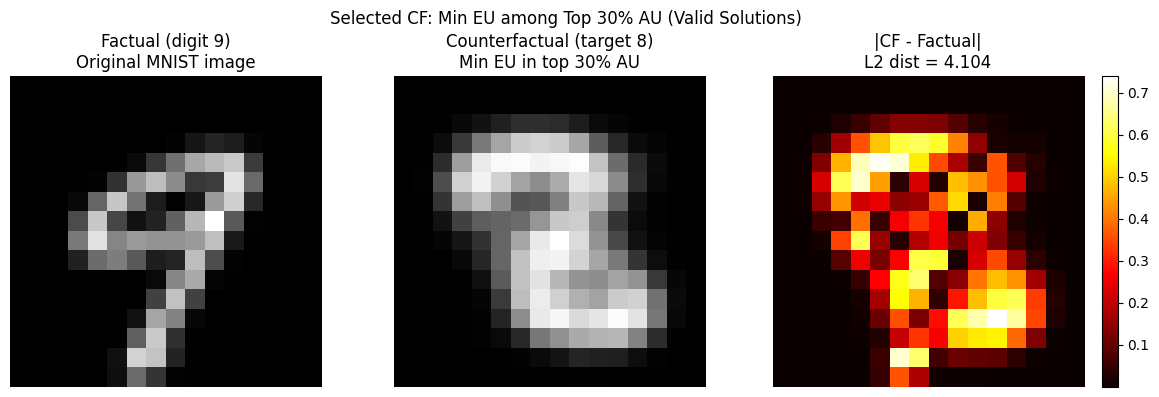

In [92]:
# VERIFICATION: Check that image distance is correctly computed
print("="*70)
print("VERIFICATION: Image Space Distance Calculation")
print("="*70)

# Select counterfactual with min EU among top 30% AU (within valid solutions)
# valid_F columns: [Validity, EU, ImgDist, -AU]
# Note: -AU is stored, so higher AU = more negative -AU = smaller value

# Get AU values (negate back to positive)
au_values = -valid_F[:, 3]

# Find threshold for top 30% AU (70th percentile)
au_threshold = np.percentile(au_values, 70)
print(f"\nAU threshold (top 30%): {au_threshold:.6f}")

# Filter to top 30% AU
top_au_mask = au_values >= au_threshold
top_au_indices = np.where(top_au_mask)[0]
print(f"Solutions with AU >= {au_threshold:.6f}: {len(top_au_indices)}")

# Among those, find the one with minimum EU
eu_values_top_au = valid_F[top_au_mask, 1]  # EU column
min_eu_idx_in_filtered = np.argmin(eu_values_top_au)
best_idx = top_au_indices[min_eu_idx_in_filtered]

print(f"\nSelected CF index: {best_idx}")
print(f"  - Validity: {valid_F[best_idx, 0]:.4f}")
print(f"  - EU: {valid_F[best_idx, 1]:.6f} (min in top 30% AU)")
print(f"  - ImgDist: {valid_F[best_idx, 2]:.4f}")
print(f"  - AU: {-valid_F[best_idx, 3]:.6f} (top 30%)")

# Take the selected counterfactual solution
z_cf = torch.tensor(valid_X[best_idx], dtype=torch.float32, device=device).unsqueeze(0)

# Generate counterfactual image using unified VAE decoder
with torch.no_grad():
    x_cf_generated = vae_model.decode(z_cf)  # Shape: (1, 1, 16, 16), range [0,1]

# Manual distance calculation
x_cf_flat = x_cf_generated.view(-1)  # (256,)
x_factual_flat = x_factual_vae.view(-1)  # (256,)

manual_dist = torch.norm(x_cf_flat - x_factual_flat).item()
problem_dist = valid_F[best_idx, 2]  # Objective 3 from optimization

print(f"\nFactual image: x_factual_vae")
print(f"  - Source: Original MNIST digit {factual_label}")
print(f"  - Shape: {x_factual_vae.shape}")
print(f"  - Value range: [{x_factual_vae.min():.3f}, {x_factual_vae.max():.3f}]")

print(f"\nCounterfactual image: vae_model.decode(z)")
print(f"  - Source: Unified VAE decoder (all digits)")
print(f"  - Shape: {x_cf_generated.shape}")
print(f"  - Value range: [{x_cf_generated.min():.3f}, {x_cf_generated.max():.3f}]")

print(f"\nDistance verification:")
print(f"  - Manual L2 distance:   {manual_dist:.6f}")
print(f"  - Problem objective 3:  {problem_dist:.6f}")
print(f"  - Match: {np.isclose(manual_dist, problem_dist, rtol=1e-4)}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(x_factual_vae[0].squeeze().cpu(), cmap='gray')
axes[0].set_title(f'Factual (digit {factual_label})\nOriginal MNIST image')
axes[0].axis('off')

axes[1].imshow(x_cf_generated[0].squeeze().cpu(), cmap='gray')
axes[1].set_title(f'Counterfactual (target {target_class})\nMin EU in top 30% AU')
axes[1].axis('off')

# Pixel-wise difference
diff = (x_cf_generated[0].squeeze() - x_factual_vae[0].squeeze()).abs().cpu()
im = axes[2].imshow(diff, cmap='hot')
axes[2].set_title(f'|CF - Factual|\nL2 dist = {manual_dist:.3f}')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

plt.suptitle('Selected CF: Min EU among Top 30% AU (Valid Solutions)', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Visualize Unified Latent Space

Key advantages of unified VAE latent space:
1. **Single shared latent space**: All digits mapped to same 2D space
2. **Smooth transitions**: Can traverse from one digit to another in latent space
3. **Natural counterfactuals**: Moving in latent space finds similar-looking alternatives
4. **Meaningful structure**: Different digit classes cluster in different regions

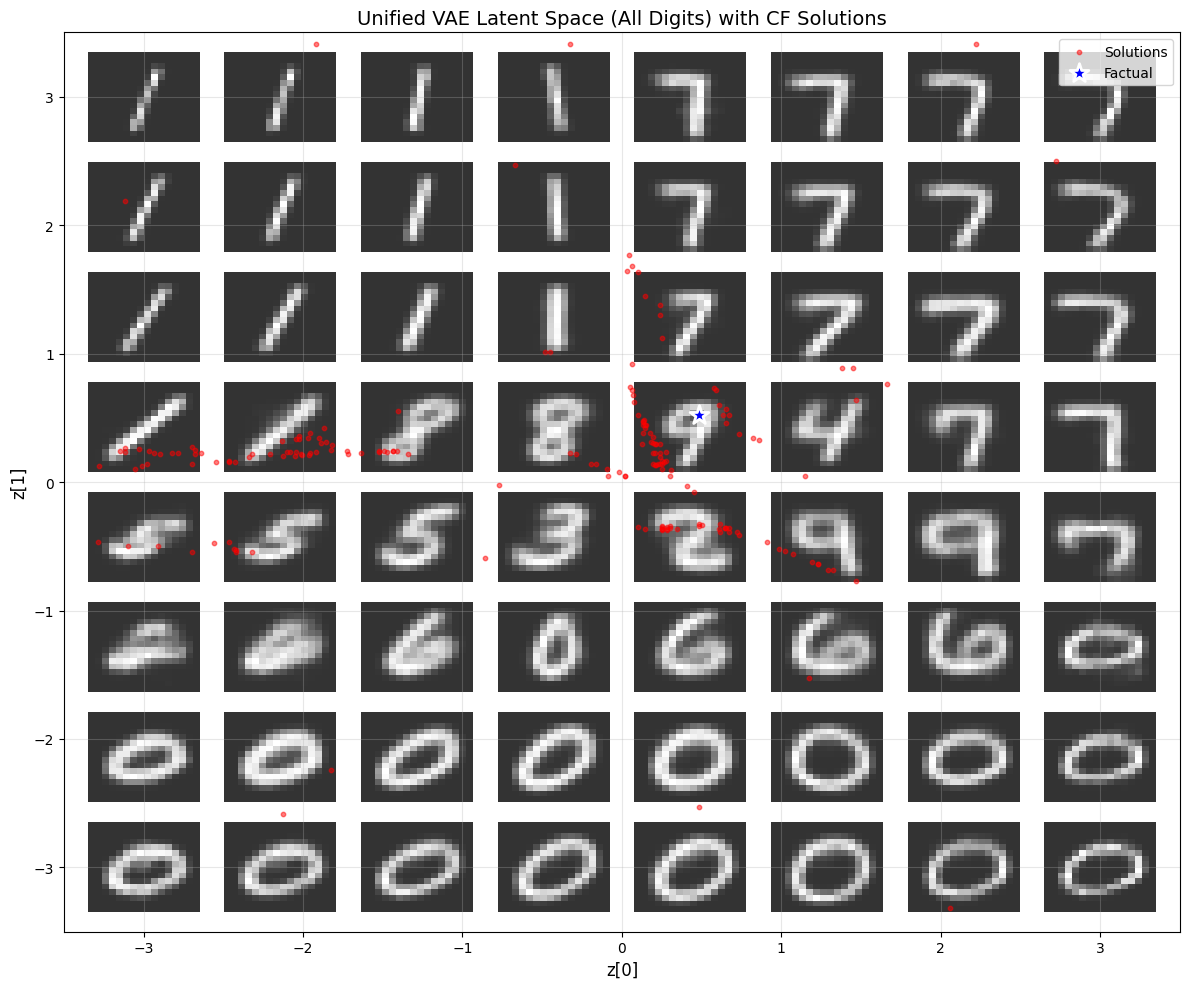

In [93]:
# Visualize unified latent space with generated images at key points
fig, ax = plt.subplots(figsize=(12, 10))

# Create a grid of latent points to visualize
n_grid = 8
z1_range = np.linspace(-3, 3, n_grid)
z2_range = np.linspace(-3, 3, n_grid)

# Generate images for the grid using unified VAE
with torch.no_grad():
    for i, z1 in enumerate(z1_range):
        for j, z2 in enumerate(z2_range):
            z = torch.tensor([[z1, z2]], dtype=torch.float32, device=device)
            img = vae_model.decode(z).cpu().squeeze().numpy()
            
            # Calculate position for the image
            extent = [
                z1 - 0.35, z1 + 0.35,
                z2 - 0.35, z2 + 0.35
            ]
            ax.imshow(img, extent=extent, cmap='gray', aspect='auto', alpha=0.8)

# Overlay the found solutions
ax.scatter(results.X[:, 0], results.X[:, 1], c='red', s=10, alpha=0.5, label='Solutions')
ax.scatter(z_factual[0, 0].cpu(), z_factual[0, 1].cpu(), 
           c='blue', s=200, marker='*', label='Factual', edgecolors='white', linewidths=2)

ax.set_xlabel('z[0]', fontsize=12)
ax.set_ylabel('z[1]', fontsize=12)
ax.set_title(f'Unified VAE Latent Space (All Digits) with CF Solutions', fontsize=14)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Clean up GPU memory
torch.cuda.empty_cache()